# Nearest neighbor analysis

## Libraries and settings

In [1]:
# Install specific version of scipy
# !pip install scipy==1.7.1

# Libraries
import folium
import pandas as pd
import seaborn as sns
import geopandas as gdp
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Import functions to calculate nearest-neighbors
import nn_functions as nn

## Prepare geodataframe of apartments data

In [2]:
# Read apartments data
df_app = pd.read_csv('apartments_data_enriched.csv', 
                      sep=',', 
                      encoding='utf-8')[['web-scraper-order', 
                                         'lat', 
                                         'lon',
                                         'address_raw',
                                         'bfs_number',
                                         'bfs_name']]

# Convert data frame of apartments data to geodataframe
df_app_geo = gdp.GeoDataFrame(df_app, 
                        geometry=gdp.points_from_xy(df_app['lon'], 
                                                    df_app['lat']))

# Set Coordinate Reference System (CRS)
df_app_geo.set_crs(4326, allow_override=True)
df_app_geo.head()

,web-scraper-order,lat,lon,address_raw,bfs_number,bfs_name,geometry
0,1662023695-433,47.255714,8.804976,"Sunnenbergstrasse 15, 8633 Wolfhausen, ZH",112,Bubikon,POINT (8.80498 47.25571)
1,1662023720-634,47.254879,8.793746,"Blumenbergstrasse 7, 8633 Wolfhausen, ZH",112,Bubikon,POINT (8.79375 47.25488)
2,1662023745-834,47.277386,8.800306,"8608 Bubikon, ZH",112,Bubikon,POINT (8.80031 47.27739)
3,1662023701-503,47.277386,8.800306,"8608 Bubikon, ZH",112,Bubikon,POINT (8.80031 47.27739)
4,1662023745-820,47.361378,8.533339,"Lavaterstr. 63, 8002 Zürich, ZH",261,Zürich,POINT (8.53334 47.36138)


## Prepare geodataframe of supermarkets data

In [3]:
# Read supermarket data and select those with know brand
df_sup = pd.read_csv('supermarkets_data_enriched.csv', 
                     sep=',', 
                     encoding='utf-8')[['id', 
                                        'lat', 
                                        'lon',
                                        'brand',
                                        'bfs_number',
                                        'bfs_name']].dropna()
print(df_sup.shape)

# Convert data frame of apartments data to geodataframe
df_sup_geo = gdp.GeoDataFrame(df_sup, 
                       geometry=gdp.points_from_xy(df_sup['lon'], 
                                                   df_sup['lat']))

# Set Coordinate Reference System (CRS)
df_sup_geo.set_crs(4326, allow_override=True)
df_sup_geo.head()

# Subset (example)
# df_sup_geo = df_sup_geo[df_sup_geo['brand'] == 'Migros']

# Alternatively, subset of two brands (example)
# df_sup_geo = df_sup_geo[df_sup_geo['brand'].isin(['Migros', 'Coop'])]

df_sup_geo.head()

(2009, 6)


,id,lat,lon,brand,bfs_number,bfs_name,geometry
0,33126515,47.155616,9.037915,Spar,3315,Schänis,POINT (9.03792 47.15562)
1,280130028,47.155492,9.039666,ALDI,3315,Schänis,POINT (9.03967 47.15549)
2,6122906632,47.158959,9.044477,Denner,3315,Schänis,POINT (9.04448 47.15896)
3,9019298862,47.155185,9.038472,Lidl,3315,Schänis,POINT (9.03847 47.15519)
4,36726161,47.226191,8.980329,Migros,3339,Uznach,POINT (8.98033 47.22619)


## Identify closest supermarkets per apartment and calculate its distance

In [4]:
# Closest supermarket of each apartment
closest_supermarkets = nn.nearest_neighbor(df_app_geo, 
                                           df_sup_geo, 
                                           return_dist=True)

print(len(closest_supermarkets), '==', len(df_app_geo))

# Rename the geometry of closest stops gdf so that we can easily identify it
closest_supermarkets = closest_supermarkets.rename(columns={'geometry': 'closest_sup_geom'})
closest_supermarkets.head()

870 == 870


,id,lat,lon,brand,bfs_number,bfs_name,closest_sup_geom,distance
0,338156406,47.269671,8.820879,Volg,112,Bubikon,POINT (8.82088 47.26967),2340.709105
1,956494681,47.253231,8.773446,Coop,153,Hombrechtikon,POINT (8.77345 47.25323),2264.541956
2,338156406,47.269671,8.820879,Volg,112,Bubikon,POINT (8.82088 47.26967),2439.597524
3,338156406,47.269671,8.820879,Volg,112,Bubikon,POINT (8.82088 47.26967),2439.597524
4,262400822,47.364072,8.530945,Migros,261,Zürich,POINT (8.53094 47.36407),398.327277


## Merge closest supermarkets to apartments

In [5]:
# Merge supermarkets to apartments
result = pd.merge(closest_supermarkets, 
                  df_app_geo, 
                  left_index=True, 
                  right_index=True)[['web-scraper-order',
                                     'address_raw',
                                     'lat_y',
                                     'lon_y',
                                     'id',
                                     'brand',
                                     'geometry',
                                     'closest_sup_geom',
                                     'distance']]

# Rename columns
results = result.rename(columns={'lat_y': 'lat',
                                 'lon_y': 'lon'},
                        inplace = True)
result.head()

,web-scraper-order,address_raw,lat,lon,id,brand,geometry,closest_sup_geom,distance
0,1662023695-433,"Sunnenbergstrasse 15, 8633 Wolfhausen, ZH",47.255714,8.804976,338156406,Volg,POINT (8.80498 47.25571),POINT (8.82088 47.26967),2340.709105
1,1662023720-634,"Blumenbergstrasse 7, 8633 Wolfhausen, ZH",47.254879,8.793746,956494681,Coop,POINT (8.79375 47.25488),POINT (8.77345 47.25323),2264.541956
2,1662023745-834,"8608 Bubikon, ZH",47.277386,8.800306,338156406,Volg,POINT (8.80031 47.27739),POINT (8.82088 47.26967),2439.597524
3,1662023701-503,"8608 Bubikon, ZH",47.277386,8.800306,338156406,Volg,POINT (8.80031 47.27739),POINT (8.82088 47.26967),2439.597524
4,1662023745-820,"Lavaterstr. 63, 8002 Zürich, ZH",47.361378,8.533339,262400822,Migros,POINT (8.53334 47.36138),POINT (8.53094 47.36407),398.327277


## Summary statistics of distance to closest supermarkets

In [6]:
result['distance'].describe()

count     870.000000
mean      818.831571
std       810.177551
min         2.198898
25%       324.456254
50%       550.585590
75%      1016.089056
max      4847.253138
Name: distance, dtype: float64

## Boxplot of distance to closest supermarkets

<AxesSubplot: xlabel='distance'>

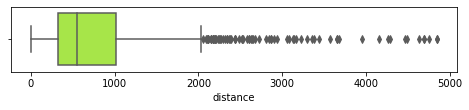

In [7]:
plt.figure(figsize=(8,1.2))
plt.ticklabel_format(style='plain')
sns.boxplot(x=result['distance'], 
            color="greenyellow")

## Plotting map with apartments and nearest supermarkets

In [8]:
# Polygonmap als .json-File (WGS84)
polys = gdp.read_file("GEN_A4_GEMEINDEN_2019_epsg4326.json")

# Marker symbols
url_01 = 'https://raw.githubusercontent.com/pointhi/leaflet-color-markers/master/img/marker-icon-blue.png'
url_02 = 'https://raw.githubusercontent.com/pointhi/leaflet-color-markers/master/img/marker-icon-gold.png'

# Initialisierung der Map
m = folium.Map(location=[47.44, 8.65], 
               # tiles='Stamen Toner', 
               zoom_start=11)

# Plot Polygonmap of municipalities
folium.Choropleth(
    geo_data=polys,
    name='polys',
    fill_color='transparent',
    line_color='darkred').add_to(m)

# Add lat/lon of apartments
for i in range(0, len(result)):
    folium.Marker(location=(result.iloc[i]['lat'],  
                            result.iloc[i]['lon']), 
                  popup=result.iloc[i]['address_raw'],
                  icon=folium.features.CustomIcon(url_01,icon_size=(14, 23))).add_to(m)
    
# Add lat/lon of apartments
for i in range(0, len(closest_supermarkets)):
    folium.Marker(location=(closest_supermarkets.iloc[i]['lat'],  
                            closest_supermarkets.iloc[i]['lon']), 
                  popup=closest_supermarkets.iloc[i]['brand'],
                  icon=folium.features.CustomIcon(url_02,icon_size=(14, 23))).add_to(m)

# Layer control
folium.LayerControl().add_to(m)

# Plot map
m

## Save data to file

In [9]:
result.to_csv('apartments_data_with_supermarkets.csv', 
              sep=",", 
              encoding='utf-8',
              index=False)

### Jupyter notebook --footer info-- (please always provide this at the end of each submitted notebook)

In [10]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
NT
Windows | 10
Datetime: 2023-01-21 18:09:57
Python Version: 3.9.7
-----------------------------------
